In [ ]:
!pip install kaggle

In [ ]:
!pip install retina-face

In [ ]:
!pip3 install wandb

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 96% 318M/330M [00:02<00:00, 159MB/s]
100% 330M/330M [00:02<00:00, 153MB/s]


In [5]:
!unzip -qq face-mask-12k-images-dataset.zip

In [21]:
import wandb
import numpy as np
import cv2
import tensorflow as tf
from wandb.keras import WandbCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from retinaface import RetinaFace
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
wandb.init(project='face-mask-recognition')

In [8]:
batch_size = 256
lr = 0.001
epoch = 40
width = height = 64

In [9]:
data_generator = ImageDataGenerator(
                                  rescale = 1 / 255,
                                  horizontal_flip = True
                                  )

train_data = data_generator.flow_from_directory("Face Mask Dataset/Train/",
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = True
                                                    )

val_data = data_generator.flow_from_directory("Face Mask Dataset/Validation/",
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = True
                                                    )

test_data = data_generator.flow_from_directory("Face Mask Dataset/Test/",
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = False
                                                    )

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([

    Conv2D(96, (11, 11), activation= 'relu', input_shape = (width, height, 3)),
    BatchNormalization(),
    MaxPooling2D(2),


    Conv2D(256, (11, 11), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),


    Conv2D(384, (3, 3), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),


    Conv2D(384, (3, 3), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),


    Conv2D(256, (3, 3), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),
    MaxPooling2D(2, strides= (2, 2)),


    Flatten(),


    Dense(4096, activation= 'relu'),
    Dropout(0.5),


    Dense(4096, activation= 'relu'),
    Dropout(0.5),


    Dense(1, activation='sigmoid')                          
])

In [10]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
    )

94683136/94668760 [==============================] - 1s 0us/step


In [11]:
for layer in base_model.layers[:-8]:
  layer.trainable = False

In [12]:
model = tf.keras.models.Sequential([
    base_model,
    Dense(2, activation='softmax')                          
])

In [13]:
model.compile(optimizer = tf.keras.optimizers.SGD(),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics='accuracy')

In [17]:
model.fit(train_data,
          steps_per_epoch = train_data.samples / batch_size,
          validation_data = val_data,
          validation_steps = val_data.samples / batch_size,
          epochs = 8,
          callbacks = [WandbCallback()]
)

Epoch 1/8
39/39 [==============================] - 17s 422ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0305 - val_accuracy: 0.9937
Epoch 2/8
39/39 [==============================] - 16s 411ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0279 - val_accuracy: 0.9950
Epoch 3/8
39/39 [==============================] - 16s 409ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0319 - val_accuracy: 0.9925
Epoch 4/8
39/39 [==============================] - 16s 411ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.0294 - val_accuracy: 0.9962
Epoch 5/8
39/39 [==============================] - 16s 408ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.0270 - val_accuracy: 0.9937
Epoch 6/8
39/39 [==============================] - 16s 410ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0302 - val_accuracy: 0.9937
Epoch 7/8
39/39 [==============================] - 16s 409ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0300 - val_accuracy: 0.9937
Epoch 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [18]:
model.save('/content/drive/MyDrive/facemask_model_resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis= 1)

print(confusion_matrix(test_data.classes, y_pred))
targets = set(test_data.class_indices.keys())
print('classification_report:')
print(classification_report(test_data.classes, y_pred, target_names= targets))

[[482   1]
 [  2 507]]
classification_report:
              precision    recall  f1-score   support

 WithoutMask       1.00      1.00      1.00       483
    WithMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



In [33]:
def process_and_predict(image_path):
    faces = RetinaFace.extract_faces(img_path= image_path, align= True)
    image = faces[0]
    image = cv2.resize(image, (width, height))
    plt.imshow(image)
    image = image / 255.0
    image = np.expand_dims(image, axis= 0)
    res = np.argmax(model.predict(image))
    if res == 0:
        print('with mask\n')
    else:
        print('no mask\n')

no mask



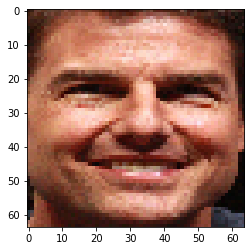

In [34]:
process_and_predict('Tom.jpeg')

with mask



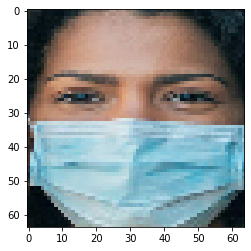

In [35]:
process_and_predict('ferferi.jpeg')